In [1]:
import numpy as np
import matplotlib.pyplot as plt
import eDiskplot
from analysis_utils import GaussianRing1d
from qdisk.classes import FitsImage
%matplotlib widget

r, I, dI = np.loadtxt("./VADP_newDDT/L1489IRS_SBLB_continuum_robust_1.0.image.tt0_radialProfileWedge45deg.txt", unpack=True)

imagename = "./VADP_newDDT/L1489IRS_SBLB_continuum_robust_1.0.image.tt0.fits"
image = FitsImage(imagename)

I /= image.Omega_beam_str
dI /= image.Omega_beam_str

In [232]:
image.Omega_beam_str

2.172399109523256e-13

In [ ]:
# Nuker profile
I0 = 1.5e-6
r0 = 5
gamma_in = 1.0
Delta = 0.2
gamma_out = 20
Delta_g = 0.3
F_g = -3.58
r0_g = 0.12
sigma_g = 0.15
r0_ring1 = 1.58
F_ring1 = -5.2
sigma_ring1 = 0.2
r0_ring2 = 2.25
F_ring2 = -5.5
sigma_ring2 = 0.18

I_Nuker = I0 * (r / r0) ** (-gamma_in) * (0.5 * (1 + (r / r0) ** (1./Delta)))**((gamma_in-gamma_out)*Delta)
I_Nuker_gapped = I_Nuker * (1. - (1. - Delta_g) * np.exp(- (r - r0_g)**2 / (2 * sigma_g**2)))
I_Nuker_gapped_ringed = I_Nuker_gapped + GaussianRing1d(r, r0_ring1, F_ring1, sigma_ring1) + GaussianRing1d(r, r0_ring2, F_ring2, sigma_ring2)
# I_Nuker_gapped = I_Nuker - GaussianRing1d(r, r0_g, F_g, sigma_g)

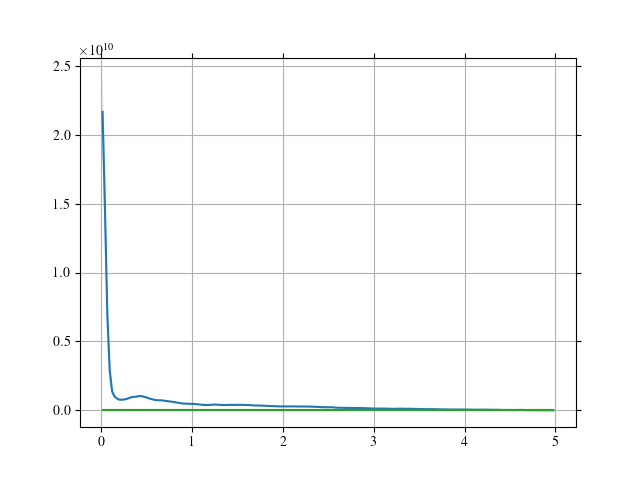

In [284]:
fig, ax = plt.subplots()
ax.plot(r, I)
ax.fill_between(r, I-dI, I+dI, alpha=0.25)
# ax.set(xscale="log", yscale="log", xlabel="Radius [au]", ylabel="$I_\\nu$ [Jy beam$^{-1}$]")

ax.plot(r, I_Nuker)
# ax.plot(r, I_Nuker - I)
ax.plot(r, I_Nuker_gapped_ringed)
ax.grid()

In [275]:
# fit with Nuker profile with gapped and ringed
import lmfit
from analysis_utils import GaussianRing1d

def Nuker_gapped_ringed(
    r,
    I0,
    r0,
    gamma_in,
    gamma_out,
    Delta,
    Delta_g,
    r0_g,
    sigma_g,
    r0_ring1,
    F_ring1,
    sigma_ring1,
    r0_ring2,
    F_ring2,
    sigma_ring2,
):
    I_Nuker = (
        I0
        * (r / r0) ** (-gamma_in)
        * (0.5 * (1 + (r / r0) ** (1.0 / Delta))) ** ((gamma_in - gamma_out) * Delta)
    )
    I_Nuker_gapped_ringed = (
        I_Nuker
        * (1.0 - (1.0 - Delta_g) * np.exp(-((r - r0_g) ** 2) / (2 * sigma_g**2)))
        # - GaussianRing1d(r, r0_g, F_g, sigma_g)
        + GaussianRing1d(r, r0_ring1, F_ring1, sigma_ring1)
        + GaussianRing1d(r, r0_ring2, F_ring2, sigma_ring2)
    )
    return I_Nuker_gapped_ringed


model = lmfit.Model(Nuker_gapped_ringed)

param_dict = {
    "I0": {"p0": 6.9e6, "bound": (1e3, 1e9), "free": True},
    "r0": {"p0": 5, "bound": (1, 10), "free": True},
    "gamma_in": {"p0": 1.0, "bound": (0.1, 10), "free": True},
    "gamma_out": {"p0": 20.0, "bound": (0.1, 1e4), "free": True},
    "Delta": {"p0": 0.2, "bound": (0.01, 10), "free": True},
    "Delta_g": {"p0": 0.2, "bound": (0.01, 1.0), "free": True},
    # "F_g": {"p0": -3.58, "bound": (-6, -1), "free": True},
    "r0_g": {"p0": 0.04, "bound": (0.005, 0.5), "free": True},
    "sigma_g": {"p0": 0.15, "bound": (0.01, 1.0), "free": True},
    "r0_ring1": {"p0": 1.58, "bound": (1, 5), "free": True},
    "F_ring1": {"p0": 7.46, "bound": (3, 12), "free": True},
    "sigma_ring1": {"p0": 0.2, "bound": (0.01, 2), "free": True},
    "r0_ring2": {"p0": 2.25, "bound": (1, 5), "free": True},
    "F_ring2": {"p0": 7.16, "bound": (3, 12), "free": True},
    "sigma_ring2": {"p0": 0.18, "bound": (0.01, 2), "free": True},
}

params = model.make_params()

for name in model.param_names:
    params[name].set(
        value=param_dict[name]["p0"],
        min=param_dict[name]["bound"][0],
        max=param_dict[name]["bound"][1],
        vary=param_dict[name]["free"],
    )


In [261]:
# fit with Nuker profile with gapped
import lmfit
from analysis_utils import GaussianRing1d

def Nuker_gapped(
    r,
    I0,
    r0,
    gamma_in,
    gamma_out,
    Delta,
    Delta_g,
    r0_g,
    sigma_g,
):
    I_Nuker = (
        I0
        * (r / r0) ** (-gamma_in)
        * (0.5 * (1 + (r / r0) ** (1.0 / Delta))) ** ((gamma_in - gamma_out) * Delta)
    )
    I_Nuker_gapped_ringed = (
        I_Nuker
        * (1.0 - (1.0 - Delta_g) * np.exp(-((r - r0_g) ** 2) / (2 * sigma_g**2)))
        # - GaussianRing1d(r, r0_g, F_g, sigma_g)
        # + GaussianRing1d(r, r0_ring1, F_ring1, sigma_ring1)
        # + GaussianRing1d(r, r0_ring2, F_ring2, sigma_ring2)
    )
    return I_Nuker_gapped_ringed


model = lmfit.Model(Nuker_gapped)

param_dict = {
    "I0": {"p0": 6.9e6, "bound": (1e3, 1e9), "free": True},
    "r0": {"p0": 5, "bound": (1, 10), "free": True},
    "gamma_in": {"p0": 1.0, "bound": (0.1, 10), "free": True},
    "gamma_out": {"p0": 20.0, "bound": (0.1, 1e4), "free": True},
    "Delta": {"p0": 0.2, "bound": (0.01, 10), "free": True},
    "Delta_g": {"p0": 0.2, "bound": (0.01, 1.0), "free": True},
    # "F_g": {"p0": -3.58, "bound": (-6, -1), "free": True},
    "r0_g": {"p0": 0.04, "bound": (0.005, 0.5), "free": True},
    "sigma_g": {"p0": 0.15, "bound": (0.01, 1.0), "free": True},
    # "r0_ring1": {"p0": 1.58, "bound": (1, 5), "free": True},
    # "F_ring1": {"p0": 7.46, "bound": (3, 12), "free": True},
    # "sigma_ring1": {"p0": 0.2, "bound": (0.01, 2), "free": True},
    # "r0_ring2": {"p0": 2.25, "bound": (1, 5), "free": True},
    # "F_ring2": {"p0": 7.16, "bound": (3, 12), "free": True},
    # "sigma_ring2": {"p0": 0.18, "bound": (0.01, 2), "free": True},
}

In [56]:
# fit with double Gaussian + ring profile
import lmfit
from analysis_utils import GaussianRing1d, Gaussian1d, FourthPowerGaussian1d, FourthPowerGaussianRing1d


def Gaussian_ringed(
    r,
    F_in,
    sigma_in,
    F_out,
    sigma_out,
    r0_ring,
    F_ring,
    sigma_ring,
    r0_ring1,
    F_ring1,
    sigma_ring1,
    r0_ring2,
    F_ring2,
    sigma_ring2,
    r0_ring3,
    F_ring3,
    sigma_ring3,
):
    I = (
        Gaussian1d(r, F_in, sigma_in)
        + Gaussian1d(r, F_out, sigma_out)
        + GaussianRing1d(r, r0_ring, F_ring, sigma_ring)
        + GaussianRing1d(r, r0_ring1, F_ring1, sigma_ring1)
        + GaussianRing1d(r, r0_ring2, F_ring2, sigma_ring2)
        + GaussianRing1d(r, r0_ring3, F_ring3, sigma_ring3)
    )
    return I


model = lmfit.Model(Gaussian_ringed)

param_dict = {
    "F_in": {"p0": 10.56, "bound": (6, 15), "free": True},
    "sigma_in": {"p0": 0.05, "bound": (0.001, 1.0), "free": True},
    "F_out": {"p0": 9.17, "bound": (4, 12), "free": True},
    "sigma_out": {"p0": 1.62, "bound": (0.5, 10), "free": True},
    "r0_ring": {"p0": 0.42, "bound": (0.01, 10.0), "free": True},
    "F_ring": {"p0": 8.3, "bound": (4, 12), "free": True},
    "sigma_ring": {"p0": 0.18, "bound": (0.02, 1.0), "free": True},
    "r0_ring1": {"p0": 0.75, "bound": (0.45, 5), "free": True},
    "F_ring1": {"p0": 8.5, "bound": (3, 12), "free": True},
    "sigma_ring1": {"p0": 0.3, "bound": (0.01, 2), "free": True},
    "r0_ring2": {"p0": 1.58, "bound": (1, 5), "free": True},
    "F_ring2": {"p0": 7.46, "bound": (3, 12), "free": True},
    "sigma_ring2": {"p0": 0.2, "bound": (0.01, 2), "free": True},
    "r0_ring3": {"p0": 2.25, "bound": (0.1, 5), "free": True},
    "F_ring3": {"p0": 7.16, "bound": (3, 12), "free": True},
    "sigma_ring3": {"p0": 0.18, "bound": (0.01, 2), "free": True}
}


In [57]:
params = model.make_params()

for name in model.param_names:
    params[name].set(
        value=param_dict[name]["p0"],
        min=param_dict[name]["bound"][0],
        max=param_dict[name]["bound"][1],
        vary=param_dict[name]["free"],
    )

result = model.fit(r=r[I>0][1:], data=I[I>0][1:], weights=dI[I>0][1:]**(-1.0), params=params, method='leastsq')

In [58]:
print(result.fit_report())

[[Model]]
    Model(Gaussian_ringed)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 379
    # data points      = 178
    # variables        = 16
    chi-square         = 129.643127
    reduced chi-square = 0.80026621
    Akaike info crit   = -24.4256539
    Bayesian info crit = 26.4828829
[[Variables]]
    F_in:         9.24246167 +/- 0.07856878 (0.85%) (init = 10.56)
    sigma_in:     0.05431986 +/- 0.00261352 (4.81%) (init = 0.05)
    F_out:        9.34562066 +/- 0.00437502 (0.05%) (init = 9.17)
    sigma_out:    1.78571916 +/- 0.00937765 (0.53%) (init = 1.62)
    r0_ring:      0.39979527 +/- 0.01151957 (2.88%) (init = 0.42)
    F_ring:       8.26253495 +/- 0.04195922 (0.51%) (init = 8.3)
    sigma_ring:   0.14372681 +/- 0.01499867 (10.44%) (init = 0.18)
    r0_ring1:     0.72914562 +/- 0.03345191 (4.59%) (init = 0.75)
    F_ring1:      7.66431247 +/- 0.14042816 (1.83%) (init = 8.5)
    sigma_ring1:  0.11640991 +/- 0.01993967 (17.13%) (init = 0.3)
    r0

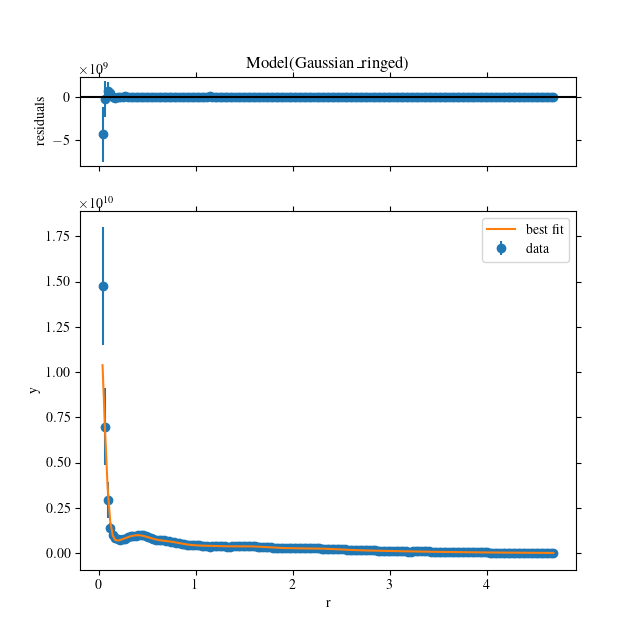

In [60]:
fig = result.plot(data_kws=dict(zorder=-100))
# fig.axes[1].set(xscale="log", yscale="log")

In [39]:
result.best_values

{'F_in': 9.041590678413328,
 'sigma_in': 0.05501519391384729,
 'F_out': 9.343098885874422,
 'sigma_out': 1.7894709355410248,
 'r0_ring': 0.4084151148883256,
 'F_ring': 8.422875787893766,
 'sigma_ring': 0.23902994773457711,
 'r0_ring1': 1.5860936866402042,
 'F_ring1': 7.157710148008144,
 'sigma_ring1': 0.13707492209645605,
 'r0_ring2': 2.29165363473926,
 'F_ring2': 7.224267486799131,
 'sigma_ring2': 0.17342501540269625}

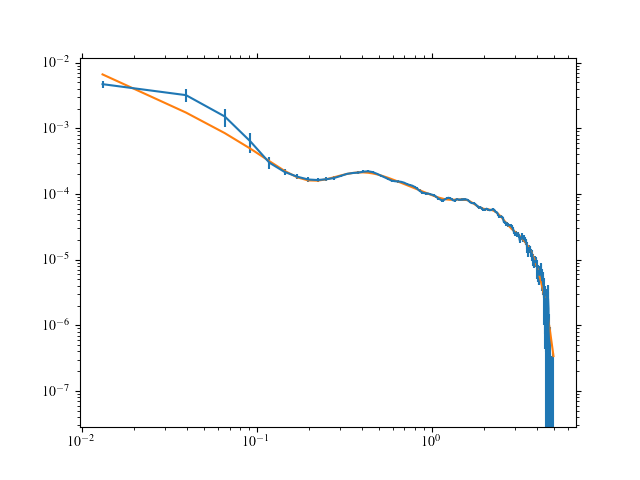

In [228]:
model = Nuker_gapped_ringed(r, **result.best_values)

plt.figure()
plt.errorbar(r, I, yerr=dI)
plt.plot(r, model)
plt.yscale("log")
plt.xscale("log")